# Script to prompt LLMs

In [3]:
# import packages
import requests
import json
import pandas as pd
import os
import openai
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

from visualization import *
from utils import *

# import warning
import warnings
warnings.filterwarnings("ignore")

In [4]:
%load_ext autoreload
%autoreload 2

In [3]:
# If OpenAI used
# Get API key from the environment variable
api_key = os.environ.get('OPENAI_API_KEY')

# Set the API key
openai.api_key = api_key

In [108]:
# Define function to create a prompt
def create_prompt(object_name, N_responses):
    prompt = f"""
    You are a very creative, open-minded person who can propose creative, out-of-the-box ideas while staying realistic. 
    
    You are meant to assist students in group ideation. They are asked to propose alternative uses for an object,
    and you should share your ideas of alternative uses to inspire them to explore other possibilities. 
    Your ideas will be especially appreciated if they are original, useful in real life, or both.
    
    Generate exactly {N_responses} alternative uses for the object [{object_name}]. 
    
    Each alternative use should be a concise sentence and follow the same format as the examples below: 
    Sock, Color it and maybe make a snake
    Sock, Use it as a puppet
    """
    return prompt

# Define function to call the LLM API
def call_openai_api(prompt, llm):
    client = OpenAI()
    
    response = client.chat.completions.create(
        model = llm,
        #model = "gpt-3.5-turbo-0125",
        #model="gpt-4-0125-preview", 
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
            ]#,
        #seed=seed,
        #max_tokens=200,
        #temperature=temperature,
        )
    return response


# Define function to store the result in a JSON file
def store_result_json(object_name, alternative_uses, path_folder_to_save, llm_name):
    result = [{"object_name": object_name, "alternative_uses": use} for use in  alternative_uses.split("\n") if use.strip()]
    with open(path_folder_to_save + f"/{llm_name}_aut_{object_name}.json", "w") as json_file:
        json.dump(result, json_file)


# Define function to create a CSV file and Pandas DataFrame
def create_csv_and_dataframe(object_name, path_folder_to_save, llm_name):
    with open(path_folder_to_save + f"/{llm_name}_aut_{object_name}.json", "r") as json_file:
        data = json.load(json_file)
    df = pd.DataFrame(data)
    
    # remove the first and last lines of the alternative uses
    df = df.iloc[1:-1].reset_index(drop=True)
    
    # remove prefix
    df['alternative_uses']= df['alternative_uses'].apply(lambda x: x.split(", ", 1)[1])
    
    #rename the columns to fit ocsai format
    df = df.rename(columns={"object_name": "prompt", "alternative_uses": "response"})
    
    # save for evaluation
    df.to_csv(path_folder_to_save + f"/{llm_name}_aut_{object_name}.csv", index=False)
    
    # Delete the JSON file
    os.remove(path_folder_to_save + f"/{llm_name}_aut_{object_name}.json")
    
    return df

# Define function to estimate the price of an OpenAI API request
def estimate_price(prompt_tokens, response_tokens, llm_name):
    # Define your pricing model (e.g., price per token)
    if llm_name == "gpt35":
        price_per_input_token = 0.50 / 1e6 # gpt3.5-turbo-0125
        price_per_output_token = 1.5 / 1e6 # gpt3.5-turbo-0125
    elif llm_name == "gpt4":
        price_per_input_token = 10 / 1e6 # gpt4-0125-preview
        price_per_output_token = 30 / 1e6 # gpt4-0125-preview
    else:
        price_per_input_token = 0
        price_per_output_token = 0
        print("Error with the price estimation (wrong name of model)")
    
    # Estimate the price based on the total number of tokens
    price = (prompt_tokens * price_per_input_token) + (response_tokens * price_per_output_token)
    return price

def pipeline_object(object_name, llm, llm_name, N_responses, path_folder_to_save):
    
    prompt = create_prompt(object_name, N_responses)
    response = call_openai_api(prompt, llm)
    
    response_content = response.choices[0].message.content
    system_fingerprint = response.system_fingerprint
    prompt_tokens = response.usage.prompt_tokens
    completion_tokens = response.usage.total_tokens - response.usage.prompt_tokens

    print(f"System fingerprint: {system_fingerprint}")
    print(f"Prompt tokens: {prompt_tokens}")
    print(f"Completion tokens: {completion_tokens}")

    price = estimate_price(prompt_tokens, completion_tokens, llm_name)
    print(f"Estimated price: ${price}")
    
    # store
    store_result_json(object_name, response_content, path_folder_to_save, llm_name)
    df = create_csv_and_dataframe(object_name, path_folder_to_save, llm_name)
    return df

In [87]:
# function for few shot prompting

def extract_human_responses(object_name, N_fs_responses, method):
    """
    Extract the most original responses from the ground truth data
    """
    # load data from humans
    humans = pd.read_csv('./data_processed/humans_data_processed.csv')
    # filter the data for the object
    object_data = humans[humans['prompt'] == object_name]
    
    # filter out data with less than 5 words
    object_data = object_data[object_data['response'].apply(lambda x: len(x.split()) >= 5)]
    
    if method == "best":
        # sort the data by the target value
        object_data_sorted = object_data.sort_values(by='originality', ascending=False)
        # extract the N most original responses
        most_original_responses = object_data_sorted.head(N_fs_responses)
        
        # reformate to have the format "object, alternative use"
        fs_examples = object_name + ', ' + most_original_responses['response'].values
        originality_scores = most_original_responses['originality'].values
    elif method == "random":
        # extract N random responses
        most_original_responses = object_data.sample(N_fs_responses, random_state=42)
        
        # reformate to have the format "object, alternative use"
        fs_examples = object_name + ', ' + most_original_responses['response'].values
        originality_scores = most_original_responses['originality'].values
    else:
        print("Error with the method")
    
    return "\n".join(fs_examples), originality_scores

def create_prompt_few_shot(object_name, N_responses, fs_examples, fs_scores):
    prompt = f"""
    You are a very creative, open-minded person who can propose creative, out-of-the-box ideas while staying realistic. 
    
    You are meant to assist students in group ideation. They are asked to propose alternative uses for an object,
    and you should share your ideas of alternative uses to inspire them to explore other possibilities. 
    Your ideas will be especially appreciated if they are original, useful in real life, or both.
    
    Generate exactly {N_responses} alternative uses for the object [{object_name}]. 
    
    Each alternative use should be a concise sentence and follow the same format as the examples below: 
{fs_examples}
    """
    
    prompt_with_scores = f"""
    You are a very creative, open-minded person who can propose creative, out-of-the-box ideas while staying realistic. 
    
    You are meant to assist students in group ideation. They are asked to propose alternative uses for an object,
    and you should share your ideas of alternative uses to inspire them to explore other possibilities. 
    Your ideas will be especially appreciated if they are original, useful in real life, or both.
    
    Generate exactly {N_responses} alternative uses for the object [{object_name}]. 
    
    Each alternative use should be a concise sentence and follow the same format as the examples below: 
{fs_examples}

    Below are the originality scores for each example listed in order. The scores are on a scale from 0 to 5,
    with 0 being not original and 5 being very original.
    Use these scores to understand what makes an idea original, but do not include them in your output.
    Originality scores:
    {fs_scores.tolist()}
    """
    
    return prompt_with_scores

def pipeline_object_few_shot(object_name, llm, llm_name, N_responses, path_folder_to_save, N_fs_responses, method):
    
    # extract the most original responses
    fs_examples, originality_scores = extract_human_responses(object_name, N_fs_responses, method=method)
    prompt = create_prompt_few_shot(object_name, N_responses, fs_examples, originality_scores)
    
    print(prompt)
    print("\n")
    response = call_openai_api(prompt, llm)
    
    response_content = response.choices[0].message.content
    system_fingerprint = response.system_fingerprint
    prompt_tokens = response.usage.prompt_tokens
    completion_tokens = response.usage.total_tokens - response.usage.prompt_tokens

    print(f"System fingerprint: {system_fingerprint}")
    print(f"Prompt tokens: {prompt_tokens}")
    print(f"Completion tokens: {completion_tokens}")

    price = estimate_price(prompt_tokens, completion_tokens, llm_name)
    print(f"Estimated price: ${price}")
    
    # store
    store_result_json(object_name, response_content, path_folder_to_save, llm_name)
    df = create_csv_and_dataframe(object_name, path_folder_to_save, llm_name)
    return df

In [6]:
objects = ['brick', 'box', 'knife', 'rope']

## Call to OpenAI API

### 0-shot prompting

In [9]:
# Run the pipeline for each object
object_name = objects[0]
path_folder_to_save = "./data_to_process/prompt_7"
#llm = "gpt-3.5-turbo-0125"
#llm_name = "gpt35"
llm = "gpt-4-0125-preview"
llm_name = "gpt4"

df = pipeline_object(object_name, llm, llm_name, 10, path_folder_to_save)
print(f"length of df: {len(df)}")
df.head()

System fingerprint: None
Prompt tokens: 147
Completion tokens: 175
Estimated price: $0.00672
length of df: 8


,prompt,response
0,brick,Install multiple bricks as bookends on a shelf.
1,brick,Decoratively paint and seal it to use as a doo...
2,brick,Create a makeshift outdoor grill by arranging ...
3,brick,Embed into the garden soil as plant markers af...
4,brick,Drill holes to turn it into a unique pencil ho...


### Few-shot prompting

In [139]:
object_name  = objects[0]
path_folder_to_save = "./data_to_process/prompt_fs_2"
llm = "gpt-3.5-turbo-0125"
llm_name = "gpt35"
#llm = "gpt-4-0125-preview"
#llm_name = "gpt4"

N_responses = 10
N_fs_examples = 5

df = pipeline_object_few_shot(object_name, llm, llm_name, N_responses, path_folder_to_save, N_fs_examples, method="random")
print(f"length of df: {len(df)}")
df.head()


    You are a very creative, open-minded person who can propose creative, out-of-the-box ideas while staying realistic. 
    
    You are meant to assist students in group ideation. They are asked to propose alternative uses for an object,
    and you should share your ideas of alternative uses to inspire them to explore other possibilities. 
    Your ideas will be especially appreciated if they are original, useful in real life, or both.
    
    Generate exactly 10 alternative uses for the object [brick]. 
    
    Each alternative use should be a concise sentence and follow the same format as the examples below: 
brick, place flowers in the holes of the brick
brick, hot "" instead of potato
brick, support for holding a fishing pole after it has been casted.
brick, Polish the  sell for profit.
brick, block a door from closing/opening

    Below are the originality scores for each example listed in order. The scores are on a scale from 0 to 5,
    with 0 being not original and 5 bein

,prompt,response
0,brick,DIY bookend for a home library
1,brick,paperweight for windy outdoor picnics
2,brick,makeshift hammer for light construction work
3,brick,base for a DIY outdoor coffee table
4,brick,doorstop to prevent a door from slamming shut


### Evaluate originality with ocsai

In [36]:
#%%capture
for i in tqdm(range(len(df))):
    eval_ocsai = call_api_ocsai(df.loc[i, 'prompt'], df.loc[i, 'response'])['scores'][0]
    df.loc[i, 'originality'] = eval_ocsai['originality']
    df.loc[i, 'elaboration'] = eval_ocsai['elaboration']
df.head()

100%|██████████| 99/99 [03:16<00:00,  1.98s/it]


,prompt,response,originality,elaboration
0,rope,create a makeshift clothesline.,1.3,4.0
1,rope,use as a belt for fashion or necessity.,1.3,8.0
2,rope,form a swing for children or decoration.,1.3,7.0
3,rope,braid into a sturdy dog leash.,1.3,6.0
4,rope,coil into a DIY rustic coaster.,3.3,6.0


In [37]:
# check if there are any NaNs
if df.isnull().values.any():
    print("There are NaNs in the DataFrame")
    N_rows_deleted = len(df[df.isnull().any(axis=1)])
    
    # remove lines with NaNs
    df = df.dropna().reset_index(drop=True)
    df.to_csv(path_folder_to_save + f"/{llm_name}_{N_fs_examples}_fs_aut_{object_name}.csv", index=False)
    print(f"Saved successfully by deleting {N_rows_deleted} row(s) with NaNs")
else:
    df.to_csv(path_folder_to_save + f"/{llm_name}_{N_fs_examples}_fs_aut_{object_name}.csv", index=False)
    print("Saved successfully")

Saved successfully


### Combine different objects together

In [38]:
df_brick = pd.read_csv(path_folder_to_save + f"/{llm_name}_{N_fs_examples}_fs_aut_brick.csv")
df_box   = pd.read_csv(path_folder_to_save + f"/{llm_name}_{N_fs_examples}_fs_aut_box.csv")
df_knife = pd.read_csv(path_folder_to_save + f"/{llm_name}_{N_fs_examples}_fs_aut_knife.csv")
df_rope  = pd.read_csv(path_folder_to_save + f"/{llm_name}_{N_fs_examples}_fs_aut_rope.csv")

# merge the datasets for all objects
df_merged = pd.concat([df_brick, df_box, df_knife, df_rope])
print(f"Length of the merged dataset: {len(df_merged)}")
print(f"Object: {df_merged['prompt'].value_counts()}")

# save dataset: change name
df_merged.to_csv(path_folder_to_save + f"/{llm_name}_merged_{N_fs_examples}_fs_{len(df_merged)}.csv", index=False) 

df_merged.head()

Length of the merged dataset: 393
Object: prompt
rope     99
brick    98
box      98
knife    98
Name: count, dtype: int64


,prompt,response,originality,elaboration
0,brick,transform it into a bookend on a bookshelf.,1.0,8.0
1,brick,heat it up to use as a bed warmer on cold nights.,3.0,12.0
2,brick,bury it partially in the garden as a quirky pl...,2.5,11.0
3,brick,use it as a weight to press flowers or leaves ...,3.0,13.0
4,brick,turn it into a mouse pad by covering it with f...,3.0,11.0


## Generate and evaluate for all objects at once

In [150]:
#%%capture # delete the output because OCSAI API calls are outputting warnings

### PARAMETERS ###
path_folder_to_save = "./data_to_process/prompt_fs_2"
#llm = "gpt-3.5-turbo-0125"
#llm_name = "gpt35"
llm = "gpt-4-0125-preview"
llm_name = "gpt4"
Nb_alternative_uses = 100
N_fs_examples = 20
##################

for i in range(4):
    print("Start generating alternative uses for the object: ", objects[i])
    object_name = objects[i]

    #df = pipeline_object(object_name, llm, llm_name, Nb_alternative_uses, path_folder_to_save)
    df = pipeline_object_few_shot(object_name, llm, llm_name, Nb_alternative_uses, path_folder_to_save, N_fs_examples, method="random")

    for i in tqdm(range(len(df))):
        eval_ocsai = call_api_ocsai(df.loc[i, 'prompt'], df.loc[i, 'response'])['scores'][0]
        df.loc[i, 'originality'] = eval_ocsai['originality']
        df.loc[i, 'elaboration'] = eval_ocsai['elaboration']
        
    # check if there are any NaNs
    if df.isnull().values.any():
        print("There are NaNs in the DataFrame")
    else:
        df.to_csv(path_folder_to_save + f"/{llm_name}_{N_fs_examples}_fs_aut_{object_name}.csv", index=False)
        print("Saved successfully")
    
df_brick = pd.read_csv(path_folder_to_save + f"/{llm_name}_{N_fs_examples}_fs_aut_brick.csv")
df_box   = pd.read_csv(path_folder_to_save + f"/{llm_name}_{N_fs_examples}_fs_aut_box.csv")
df_knife = pd.read_csv(path_folder_to_save + f"/{llm_name}_{N_fs_examples}_fs_aut_knife.csv")
df_rope  = pd.read_csv(path_folder_to_save + f"/{llm_name}_{N_fs_examples}_fs_aut_rope.csv")

# merge the datasets for all objects
df_merged = pd.concat([df_brick, df_box, df_knife, df_rope])

# save dataset
df_merged.to_csv(path_folder_to_save + f"/{llm_name}_merged_{N_fs_examples}_fs_{len(df_merged)}.csv", index=False) 

Start generating alternative uses for the object:  brick

    You are a very creative, open-minded person who can propose creative, out-of-the-box ideas while staying realistic. 
    
    You are meant to assist students in group ideation. They are asked to propose alternative uses for an object,
    and you should share your ideas of alternative uses to inspire them to explore other possibilities. 
    Your ideas will be especially appreciated if they are original, useful in real life, or both.
    
    Generate exactly 100 alternative uses for the object [brick]. 
    
    Each alternative use should be a concise sentence and follow the same format as the examples below: 
brick, place flowers in the holes of the brick
brick, hot "" instead of potato
brick, support for holding a fishing pole after it has been casted.
brick, Polish the  sell for profit.
brick, block a door from closing/opening
brick, using tools to mold or shape them into figurines
brick, Use to mash things up
brick, H

100%|██████████| 98/98 [03:47<00:00,  2.32s/it]


Saved successfully
Start generating alternative uses for the object:  box

    You are a very creative, open-minded person who can propose creative, out-of-the-box ideas while staying realistic. 
    
    You are meant to assist students in group ideation. They are asked to propose alternative uses for an object,
    and you should share your ideas of alternative uses to inspire them to explore other possibilities. 
    Your ideas will be especially appreciated if they are original, useful in real life, or both.
    
    Generate exactly 100 alternative uses for the object [box]. 
    
    Each alternative use should be a concise sentence and follow the same format as the examples below: 
box, flying into outer space to have sex on the moon
box, cut and cover up with it for warmth
box, make a halloween mask out of it
box, make signs out of the sides
box, you can use it as a step stool
box, If it has a lid  it could be a talking if one drew a face on it
box, use it cushion one's fall wh

100%|██████████| 98/98 [03:23<00:00,  2.07s/it]


Saved successfully
Start generating alternative uses for the object:  knife

    You are a very creative, open-minded person who can propose creative, out-of-the-box ideas while staying realistic. 
    
    You are meant to assist students in group ideation. They are asked to propose alternative uses for an object,
    and you should share your ideas of alternative uses to inspire them to explore other possibilities. 
    Your ideas will be especially appreciated if they are original, useful in real life, or both.
    
    Generate exactly 100 alternative uses for the object [knife]. 
    
    Each alternative use should be a concise sentence and follow the same format as the examples below: 
knife, hang car keys on it
knife, when climbing a wooden wall and you need an extra hand hold, you can stab it into the wood
knife, to open a lock/locked door
knife, to carve chess pieces out of wood
knife, cut the hair off your legs
knife, look at your own reflection
knife, stab or cut something 

100%|██████████| 88/88 [03:01<00:00,  2.06s/it]


Saved successfully
Start generating alternative uses for the object:  rope

    You are a very creative, open-minded person who can propose creative, out-of-the-box ideas while staying realistic. 
    
    You are meant to assist students in group ideation. They are asked to propose alternative uses for an object,
    and you should share your ideas of alternative uses to inspire them to explore other possibilities. 
    Your ideas will be especially appreciated if they are original, useful in real life, or both.
    
    Generate exactly 100 alternative uses for the object [rope]. 
    
    Each alternative use should be a concise sentence and follow the same format as the examples below: 
rope, use to climb a mountain
rope, tying it onto a four wheeler and attaching a sled at the other end and pulling the sled behind the four wheeler using the
rope, make a shoe out of
rope, lasso for astronauts to catch aliens
rope, Hang it on a wall to divide it up
rope, use   to pull out teeth
rope

100%|██████████| 98/98 [03:20<00:00,  2.04s/it]

Saved successfully


In [151]:
print(f"Length of the merged dataset: {len(df_merged)}")
print(f"Object: {df_merged['prompt'].value_counts()}")
df_merged.head()

Length of the merged dataset: 382
Object: prompt
brick    98
box      98
rope     98
knife    88
Name: count, dtype: int64


,prompt,response,originality,elaboration
0,brick,grind into powder for pottery glaze.,3.0,6.0
1,brick,improvised bookend.,1.5,2.0
2,brick,create a garden path.,1.0,4.0
3,brick,heat in the oven for a pizza stone.,3.0,8.0
4,brick,use as a base for candle making.,3.0,7.0


## Experiment

In [86]:
#N_fs_responses = 10
#object_name = objects[0]
#N_response = 30
#
#fs_examples, originality_scores = extract_human_responses(object_name, N_fs_responses, method="best")
#prompt = create_prompt_few_shot(object_name, N_responses, fs_examples, fs_scores= originality_scores)
#
#print(fs_examples)
#print("\n")
#print(originality_scores)
#print("\n")
#print(prompt)




brick, make it into a superhero called The Wall and have him fight Erosion Man
brick, add a lens to the wholes in a and create some sort of binocular or glasses
brick, use it to create a pattern in paint and then stamp in onto paper
brick, Crush a into a fine  sand-like powder and use it as a makeshift water filter
brick, for water displacement in a science experiment
brick, break into pieces to make a puzzle
brick, brick powder can use for teethcleaning
brick, chop it in a karate gym
brick, aid in color identification for children
brick, pranking by putting them in someone's bookbag


[5.  5.  5.  5.  5.  5.  4.8 4.7 4.7 4.7]



    You are a very creative, open-minded person who can propose creative, out-of-the-box ideas while staying realistic. 
    
    You are meant to assist students in group ideation. They are asked to propose alternative uses for an object,
    and you should share your ideas of alternative uses to inspire them to explore other possibilities. 
    Your ideas wi

### Experiment: Consistency

1) OCSAI
2) GPT models

In [93]:
object_name = objects[0]
path_folder_to_save = "./data_to_process"
llm = "gpt-3.5-turbo-0125"
llm_name = "gpt35"
#llm = "gpt-4-0125-preview"
#llm_name = "gpt4"

df = pipeline_object(object_name, llm, llm_name, 12, path_folder_to_save)
print(f"length of df: {len(df)}")
df.head()

System fingerprint: None
Prompt tokens: 147
Completion tokens: 196
Estimated price: $0.0003675
length of df: 10


,prompt,response
0,brick,Stack a few together to create a rustic and un...
1,brick,Wrap it in twine or fabric to fashion a unique...
2,brick,Drill a hole in the center to transform it int...
3,brick,"With proper cushioning, repurpose it as a quir..."
4,brick,String a few together to craft a rustic wind c...


In [94]:
for _, col in enumerate(['originality_run_1', 'originality_run_2', 'originality_run_3', 'originality_run_4', 'originality_run_5', 'originality_run_6', 'originality_run_7', 'originality_run_8', 'originality_run_9', 'originality_run_10']):
    for i in tqdm(range(len(df))):
        eval_ocsai = call_api_ocsai(df.loc[i, 'prompt'], df.loc[i, 'response'])['scores'][0]
        df.loc[i, col] = eval_ocsai['originality']
        #df.loc[i, 'elaboration'] = eval_ocsai['elaboration']
df.head()

100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


,prompt,response,originality_run_1,originality_run_2,originality_run_3,originality_run_4,originality_run_5,originality_run_6,originality_run_7,originality_run_8,originality_run_9,originality_run_10
0,brick,Stack a few together to create a rustic and un...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,brick,Wrap it in twine or fabric to fashion a unique...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,brick,Drill a hole in the center to transform it int...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,brick,"With proper cushioning, repurpose it as a quir...",2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,brick,String a few together to craft a rustic wind c...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


Mean -  std of the originality scores: 2.0 - 0.0
Mean -  std of the originality scores: 2.0 - 0.0
Mean -  std of the originality scores: 3.0 - 0.0
Mean -  std of the originality scores: 2.0 - 0.0
Mean -  std of the originality scores: 3.0 - 0.0
Mean -  std of the originality scores: 2.0 - 0.0
Mean -  std of the originality scores: 2.0 - 0.0
Mean -  std of the originality scores: 3.0 - 0.0
Mean -  std of the originality scores: 2.0 - 0.0
Mean -  std of the originality scores: 3.0 - 0.0


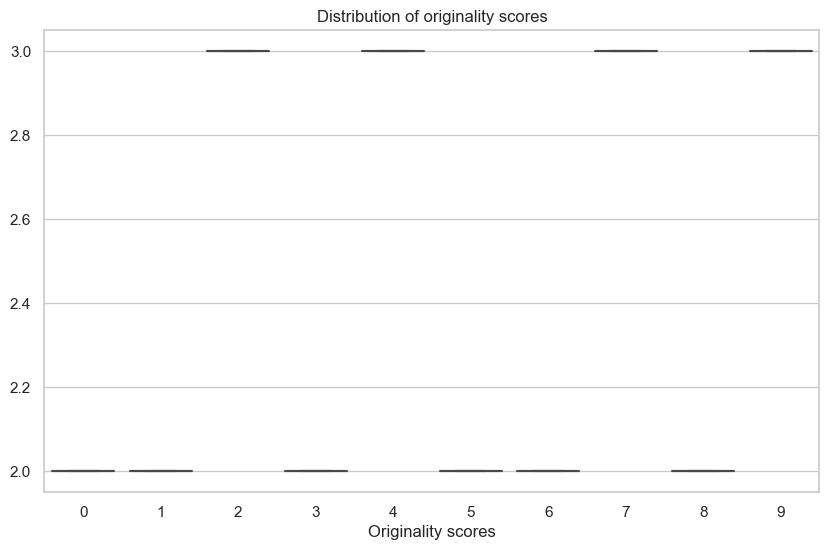

In [107]:
# combine in a list all scores of originality by adding column "list_scores"
df['list_scores'] = df[['originality_run_1', 'originality_run_2', 'originality_run_3', 'originality_run_4', 'originality_run_5', 'originality_run_6', 'originality_run_7', 'originality_run_8', 'originality_run_9', 'originality_run_10']].values.tolist()

# calculate the mean and std of the originality scores for each row
for list in df['list_scores']:
    print(f"Mean -  std of the originality scores: {np.mean(list)} - {np.std(list)}")

# plot with box plot the distribution of originality list_scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=df['list_scores'])
plt.title("Distribution of originality scores")
plt.xlabel("Originality scores")
plt.show()

In [136]:
# consistency check of GPT

# run this 10 times
object_name = 'brick'
path_folder_to_save = "./data_to_process/exp_consistency"
#llm = "gpt-3.5-turbo-0125"
#llm_name = "gpt35"
llm = "gpt-4-0125-preview"
llm_name = "gpt4"

dfs = pd.DataFrame()

for i in range(10):
    print(f"Run {i+1}")
    df = pipeline_object(object_name, llm, llm_name, 100, path_folder_to_save)
    print(f"length of df: {len(df)}")
    
    df[f'Run'] = f"run {i + 1}"
    
    # combine with other df
    dfs = pd.concat([dfs, df])
    print(len(dfs))
dfs.reset_index(drop = True, inplace = True)

Run 1
System fingerprint: None
Prompt tokens: 163
Completion tokens: 1354
Estimated price: $0.04225
length of df: 87
87
Run 2
System fingerprint: None
Prompt tokens: 163
Completion tokens: 1420
Estimated price: $0.04423
length of df: 92
179
Run 3
System fingerprint: None
Prompt tokens: 163
Completion tokens: 1270
Estimated price: $0.03973
length of df: 100
279
Run 4
System fingerprint: None
Prompt tokens: 163
Completion tokens: 1205
Estimated price: $0.03778
length of df: 91
370
Run 5
System fingerprint: None
Prompt tokens: 163
Completion tokens: 1498
Estimated price: $0.04657
length of df: 93
463
Run 6
System fingerprint: None
Prompt tokens: 163
Completion tokens: 1422
Estimated price: $0.04429
length of df: 84
547
Run 7
System fingerprint: None
Prompt tokens: 163
Completion tokens: 1213
Estimated price: $0.03802
length of df: 99
646
Run 8
System fingerprint: None
Prompt tokens: 163
Completion tokens: 1215
Estimated price: $0.03808
length of df: 85
731
Run 9
System fingerprint: None
P

In [1]:
#dfs.to_csv(path_folder_to_save + f"/gpt4_aut_brick_exp_consistency.csv", index=False)
#dfs.head()

In [132]:
# evaluate all ideas line by line
for i in tqdm(range(len(dfs))):
    eval_ocsai = call_api_ocsai(dfs.loc[i, 'prompt'], dfs.loc[i, 'response'])['scores'][0]
    dfs.loc[i, 'originality'] = eval_ocsai['originality']
    dfs.loc[i, 'elaboration'] = eval_ocsai['elaboration']
dfs.head()

100%|██████████| 813/813 [39:39<00:00,  2.93s/it]    


,prompt,response,Run,originality,elaboration
0,brick,Paint it and use it as a bookend,run 1,2.0,8.0
1,brick,Glue magnets to it for a magnetic key holder,run 1,3.0,9.0
2,brick,Break it to create mosaic art,run 1,2.0,6.0
3,brick,Attach wheels to create a movable garden stool,run 1,3.0,8.0
4,brick,String together for a unique outdoor wind chime,run 1,3.0,8.0


In [7]:
dfs_consistency_gpt_35 = pd.read_csv("./data_to_process/exp_consistency/gpt35_aut_brick_exp_consistency.csv")
dfs_consistency_gpt_4 = pd.read_csv("./data_to_process/exp_consistency/gpt4_aut_brick_exp_consistency.csv")
display(dfs_consistency_gpt_35.head(2), dfs_consistency_gpt_4.head(2))

,prompt,response,Run,originality,elaboration
0,brick,Paint it and use it as a bookend,run 1,2.0,8.0
1,brick,Glue magnets to it for a magnetic key holder,run 1,3.0,9.0


,prompt,response,Run,originality,elaboration
0,brick,Use it as a doorstop to keep doors open.,run 1,1.0,9.0
1,brick,Transform it into a bookend for your shelf.,run 1,1.0,8.0


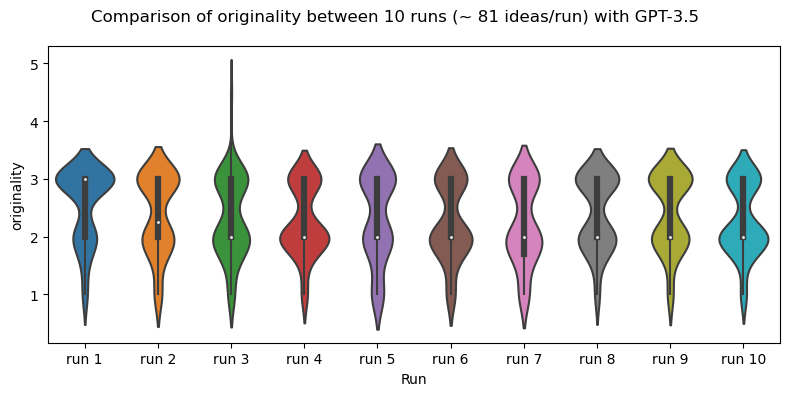

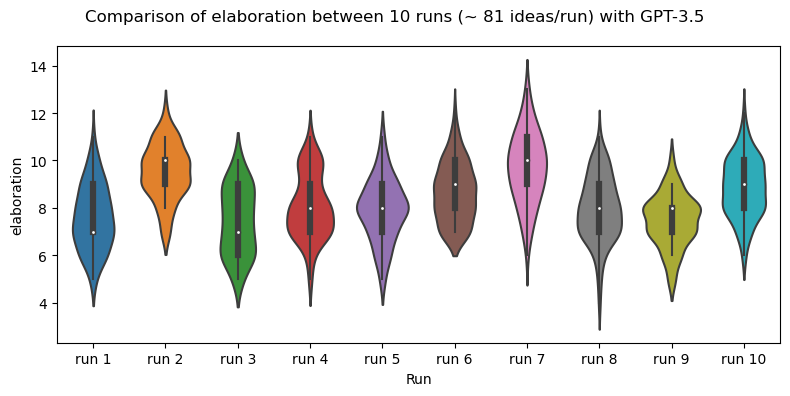

In [24]:
plt.figure(figsize=(8, 4))
sns.violinplot(data=dfs_consistency_gpt_35, x='Run', y='originality')
plt.suptitle(f"Comparison of originality between 10 runs (~ {int(0.1*len(dfs_consistency_gpt_35))} ideas/run) with GPT-3.5")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.violinplot(data=dfs_consistency_gpt_35, x='Run', y='elaboration')
plt.suptitle(f"Comparison of elaboration between 10 runs (~ {int(0.1*len(dfs_consistency_gpt_35))} ideas/run) with GPT-3.5")
plt.tight_layout()
plt.show()